<a href="https://colab.research.google.com/github/aayush1693/Fine-Tuning-BERT-for-Sentiment-Analysis/blob/main/fine_tune_bert_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-Tuning BERT Model for Sentiment Analysis**
This notebook demonstrates how to fine-tune a BERT model for sentiment analysis using the Huggingface transformers library. We'll visualize key training metrics like loss and accuracy to understand the model's performance.


1. Install Dependencies

---


First, we install the necessary libraries for working with BERT, datasets, and visualization.

In [1]:
# Install Huggingface's transformers, datasets, and other necessary libraries
!pip install transformers datasets matplotlib

# Import libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00


2. Load and Prepare Dataset

---


We'll load the SST-2 dataset for sentiment analysis and split it into training and validation sets.

In [2]:
# Load the SST-2 dataset from Huggingface
dataset = load_dataset('glue', 'sst2')

# Split dataset into training and validation
train_data = dataset['train']
test_data = dataset['validation']

# Show an example from the dataset
print(train_data[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


3. Tokenize Data

---
We use the BERT tokenizer to prepare the data for model input.


In [3]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

# Apply tokenization
train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
test_data = test_data.map(tokenize, batched=True, batch_size=len(test_data))

# Remove unnecessary columns and set format for PyTorch tensors
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Check the first tokenized example
print(train_data[0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

{'label': tensor(0), 'input_ids': tensor([  101,  5342,  2047,  3595,  8496,  2013,  1996, 18643,  3197,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


4. Load Pre-trained BERT Model

---
We now load the pre-trained BERT model with a sequence classification head (for binary classification).


In [4]:
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5. Define Metrics and Evaluation Function

---


We'll define the accuracy, precision, recall, and F1-score to evaluate the model's performance.

In [5]:
# Define the evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

6. Setup Training Arguments

---
Here, we define the training arguments such as the number of epochs, learning rate, and evaluation strategy.


In [7]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # evaluate each epoch
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # log every 10 steps
    load_best_model_at_end=True,     # load the best model at the end of training
    save_strategy="epoch",          # Save the model checkpoint at the end of each epoch
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


7. Initialize Trainer

---


We initialize the Huggingface Trainer class to handle the training loop and evaluation.

In [8]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated model
    args=training_args,                  # training arguments
    train_dataset=train_data,            # training dataset
    eval_dataset=test_data,              # evaluation dataset
    compute_metrics=compute_metrics,     # the metrics function
)

8. Train the Model and Visualize Training Loss

---
We'll now train the model and capture the training loss at each step for visualization.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.139300,0.328763,0.900229,0.898246,0.934307,0.864865
2,0.105400,0.401748,0.901376,0.908316,0.862348,0.959459
3,0.051900,0.356986,0.915138,0.917778,0.905702,0.930180


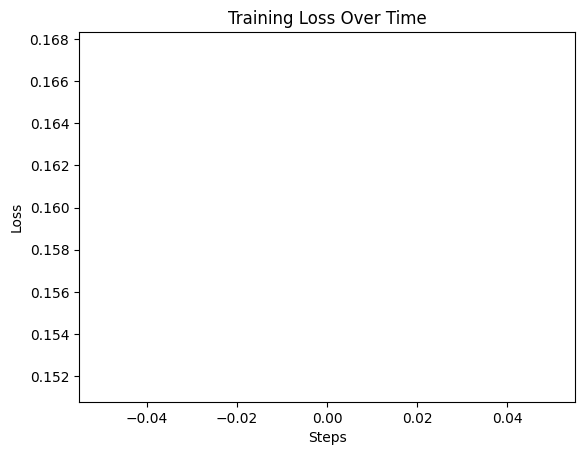

In [9]:
# Train the model
train_result = trainer.train()

# Save the model and tokenizer
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')

# Plot training loss
plt.plot(train_result.training_loss)
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

9. Evaluate the Model


---


After training, we evaluate the model on the validation set to see its performance in terms of accuracy, F1-score, and more.

In [10]:
# Evaluate the model
eval_result = trainer.evaluate()

# Print the evaluation results
print("Evaluation Metrics:")
for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")

Evaluation Metrics:
eval_loss: 0.3288
eval_accuracy: 0.9002
eval_f1: 0.8982
eval_precision: 0.9343
eval_recall: 0.8649
eval_runtime: 2.8643
eval_samples_per_second: 304.4390
eval_steps_per_second: 4.8880
epoch: 3.0000


10. Visualize Training and Evaluation Metrics

---


We'll plot accuracy, precision, recall, and F1-score from the evaluation step

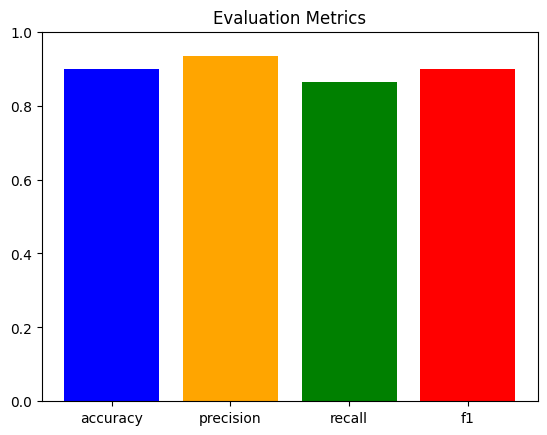

In [11]:
# Store evaluation metrics for visualization
metrics = eval_result

# Define the metric names and values
metric_names = ['accuracy', 'precision', 'recall', 'f1']
metric_values = [metrics['eval_accuracy'], metrics['eval_precision'], metrics['eval_recall'], metrics['eval_f1']]

# Plot the metrics
plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red'])
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for better readability
plt.show()

11. Inference on New Data
We can now use the fine-tuned model to make predictions on new sentences.

In [12]:
# Load the fine-tuned model
fine_tuned_model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
fine_tuned_tokenizer = BertTokenizer.from_pretrained('./fine_tuned_bert')

# Perform inference on a new sentence
sentence = "This movie is fantastic!"
inputs = fine_tuned_tokenizer(sentence, return_tensors="pt")
outputs = fine_tuned_model(**inputs)
prediction = torch.argmax(outputs.logits, dim=-1)

# Interpret the prediction
label = 'positive' if prediction == 1 else 'negative'
print(f"Sentiment: {label}")

Sentiment: positive


12. Conclusion
In this notebook, we've fine-tuned a BERT model for sentiment analysis, evaluated its performance, and visualized the training loss and evaluation metrics. The model can now be used to classify the sentiment of new sentences.